In [ ]:
# pipeline

# carregar genoma

# criar reads

# criar os k mears

# fazer o grafo de DeBruijn

# otimizar

# reconstruir o genoma

In [158]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import time

In [137]:
class Gerenciador_de_Genomas:
    def __init__(self):
        self.bases = ['A', 'C', 'G', 'T']
    def gerar_genoma(self,tamanho, random_state=None):
        random.seed(random_state)
        genoma = ''.join(random.choice(self.bases) for _ in range(tamanho))
        return genoma
    
    def gerar_reads(self,genoma, tamanho_read, cobertura=1.0,temperatura=0,random_state=None):
        reads_totais = [genoma[i:i+random.choice(range(tamanho_read-temperatura,tamanho_read+temperatura+1))]
                        for i in range(len(genoma)-tamanho_read+1)]
        numero_de_reads = int(len(reads_totais)*cobertura)
        random.seed(random_state)
        reads_cobertos = random.sample(reads_totais,numero_de_reads)
        return reads_cobertos
    
    def gerar_kmers(self, reads, k):
        kmers = set()
        for read in reads:
            for i in range(len(read) - k + 1):
                kmear = read[i:i + k]
                kmers.add(kmear)
        return list(kmers)
    
    def gerar_grafo_de_DeBruijn(self, kmers):
        Graph = nx.DiGraph()
        Graph.add_nodes_from(kmers)
        prefixos =  [kmer[:-1] for kmer in kmers]
        sufixos = [kmer[1:] for kmer in kmers]
        for i in range(len(kmers)):
            for j in range(len(kmers)):
                if prefixos[j] == sufixos[i]:
                    Graph.add_edge(kmers[i], kmers[j])
        return Graph

    def desenhar_grafo(self, grafo):
        pos = nx.spring_layout(grafo)
        plt.figure(figsize=(8, 6))
        labels_encurtados = {}
        for node in grafo.nodes():
            if len(node) > 8:
                novo_label = node[:3] + "..." + node[-3:]
            else:
                novo_label = node
            labels_encurtados[node] = novo_label
        # Desenhar grafo com os labels encurtados
        nx.draw(grafo, pos, labels=labels_encurtados,
                with_labels=True, node_size=1000,
                node_color='lightblue', font_size=8,
                font_color='black', font_weight='bold',
                arrows=True)

        plt.title("Grafo de De Bruijn")
        plt.show()

    def verificar_se_tem_caminho_euleriano(self,grafo):
        return nx.has_eulerian_path(grafo)
    
    def obter_caminho_euleriano(self,grafo):
        caminho_arestas = list(nx.eulerian_path(grafo))
        caminho = [i[0] for i in caminho_arestas] + [caminho_arestas[-1][1]]
        return caminho
    
    def reconstruir_genoma(self,caminho_euleriano):
        k = len(caminho_euleriano[0])
        novo_genoma = ""
        for i in range(len(caminho_euleriano)):
            if i == 0:
                novo_genoma += caminho_euleriano[i]
            else:
                novo_genoma += caminho_euleriano[i][k-1:]
        return novo_genoma
    
    def comparar_genormas(self,genoma1, genoma2):
        count = 0
        for i in range(len(genoma1)):
            if i > len(genoma2) -1:
                break
            if genoma1[i] == genoma2[i]:
                count +=1
        corr = count/len(genoma1)
        return corr
    
    def fundir_vertices(self,grafo,vertices):
        arestas_de_entrada = set()
        arestas_de_saida = set()
        novo_grafo = grafo.copy()
        for v in vertices:
            arestas_de_entrada = arestas_de_entrada.union(set(grafo.in_edges(v)))
            arestas_de_saida = arestas_de_saida.union(set(grafo.out_edges(v)))
        novo_grafo.remove_nodes_from(vertices)
        nome = self.reconstruir_genoma(vertices)
        arestas_de_entrada = [i for i in list(arestas_de_entrada) if not (i[0] in vertices and i[1] in vertices)]
        arestas_de_saida = [i for i in list(arestas_de_saida) if not (i[0] in vertices and i[1] in vertices)]
        novas_arestas_entrada = [(i[0],nome) for i in arestas_de_entrada]
        novas_arestas_saida = [(nome,i[1]) for i in arestas_de_saida]
        arestas = novas_arestas_entrada + novas_arestas_saida
        novo_grafo.add_node(nome)
        novo_grafo.add_edges_from(arestas)
        return novo_grafo, nome

    # talvez fazer fusão de arestas em série para simplificar o grafo
    def simplificar_grafo(self,grafo, caminho):
        graus_de_entrada = [grafo.in_degree(i) for i in caminho]
        graus_de_saida = [grafo.out_degree(i) for i in caminho]
        pode_fundir = [graus_de_entrada[i]==1 and graus_de_saida[i]==1 for i in range(len(caminho))]
        grupos_de_fusao = []
        sec = 0
        for i in range(len(pode_fundir)):
            if pode_fundir[i]:
                sec +=1
                if sec ==1:
                    grupos_de_fusao.append([caminho[i]])
                else:
                    grupos_de_fusao[-1].append(caminho[i])
            else:
                sec = 0
        novo_grafo = grafo.copy()
        novos_nomes = []
        for i in grupos_de_fusao:
            novo_grafo,novo_nome = self.fundir_vertices(novo_grafo,i)
            novos_nomes.append(novo_nome)
        return novo_grafo,novos_nomes

Genoma Original: AACCCTAACTGCATAAGTGCGCACAAGTCGTGGTGGGTTATCCTTCGGGAAACCAATCCATGACAGTTGCACGAGTTCGCCATTGAGCGTGGAAAGCGGA
Caminho: ['AACCCTAACTGCATAAGTGCGCACAAGTCGTGGTGGGTTATCCTTCGGGA', 'ACCCTAACTGCATAAGTGCGCACAAGTCGTGGTGGGTTATCCTTCGGGAA', 'CCCTAACTGCATAAGTGCGCACAAGTCGTGGTGGGTTATCCTTCGGGAAA', 'CCTAACTGCATAAGTGCGCACAAGTCGTGGTGGGTTATCCTTCGGGAAAC', 'CTAACTGCATAAGTGCGCACAAGTCGTGGTGGGTTATCCTTCGGGAAACC', 'TAACTGCATAAGTGCGCACAAGTCGTGGTGGGTTATCCTTCGGGAAACCA', 'AACTGCATAAGTGCGCACAAGTCGTGGTGGGTTATCCTTCGGGAAACCAA', 'ACTGCATAAGTGCGCACAAGTCGTGGTGGGTTATCCTTCGGGAAACCAAT', 'CTGCATAAGTGCGCACAAGTCGTGGTGGGTTATCCTTCGGGAAACCAATC', 'TGCATAAGTGCGCACAAGTCGTGGTGGGTTATCCTTCGGGAAACCAATCC', 'GCATAAGTGCGCACAAGTCGTGGTGGGTTATCCTTCGGGAAACCAATCCA', 'CATAAGTGCGCACAAGTCGTGGTGGGTTATCCTTCGGGAAACCAATCCAT', 'ATAAGTGCGCACAAGTCGTGGTGGGTTATCCTTCGGGAAACCAATCCATG', 'TAAGTGCGCACAAGTCGTGGTGGGTTATCCTTCGGGAAACCAATCCATGA', 'AAGTGCGCACAAGTCGTGGTGGGTTATCCTTCGGGAAACCAATCCATGAC', 'AGTGCGCACAAGTCGTGGTGGGTTATCCTTCGGGAAACCAATCCATGACA', 'GTGCGCA

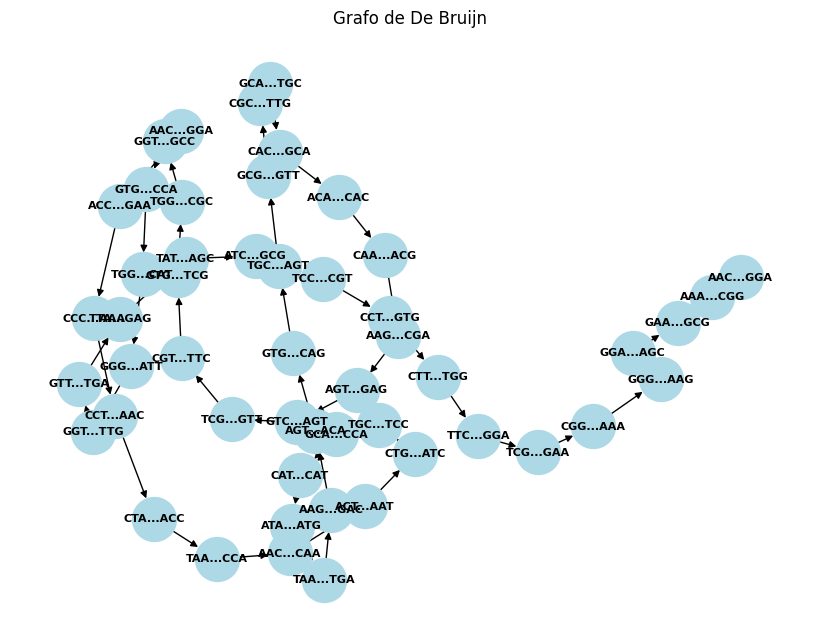

Tempo de 0.4


In [ ]:
start = time.time()
manager = Gerenciador_de_Genomas()
genoma_teste = manager.gerar_genoma(100, random_state=None)
print(f"Genoma Original: {genoma_teste}")
reads_teste = manager.gerar_reads(genoma_teste, tamanho_read=70,cobertura=1)
kmers_teste = manager.gerar_kmers(reads_teste, k=50)
grafo = manager.gerar_grafo_de_DeBruijn(kmers_teste)
if manager.verificar_se_tem_caminho_euleriano(grafo):
    caminho = manager.obter_caminho_euleriano(grafo)
    print(f"Caminho: {caminho}")
    genoma1 = manager.reconstruir_genoma(caminho)
    print(f"Genoma final: {genoma1}")
    manager.desenhar_grafo(grafo)
else:
    print("Grafo invalido")
print(f"Tempo de execução: {round(time.time() - start,2)} segundos")

Caminho: ['CCGTACAAGGTTTCTGGATTGGCCTAACCAGGACCCGCCCCCCGATACTC', 'CGTACAAGGTTTCTGGATTGGCCTAACCAGGACCCGCCCCCCGATACTCATACTTTAGTCGGAGGTAATACAATACAGTGCAGTAGTTTGTTCATGGG', 'ATACTTTAGTCGGAGGTAATACAATACAGTGCAGTAGTTTGTTCATGGGG']
Genoma final: CCGTACAAGGTTTCTGGATTGGCCTAACCAGGACCCGCCCCCCGATACTCATACTTTAGTCGGAGGTAATACAATACAGTGCAGTAGTTTGTTCATGGGG


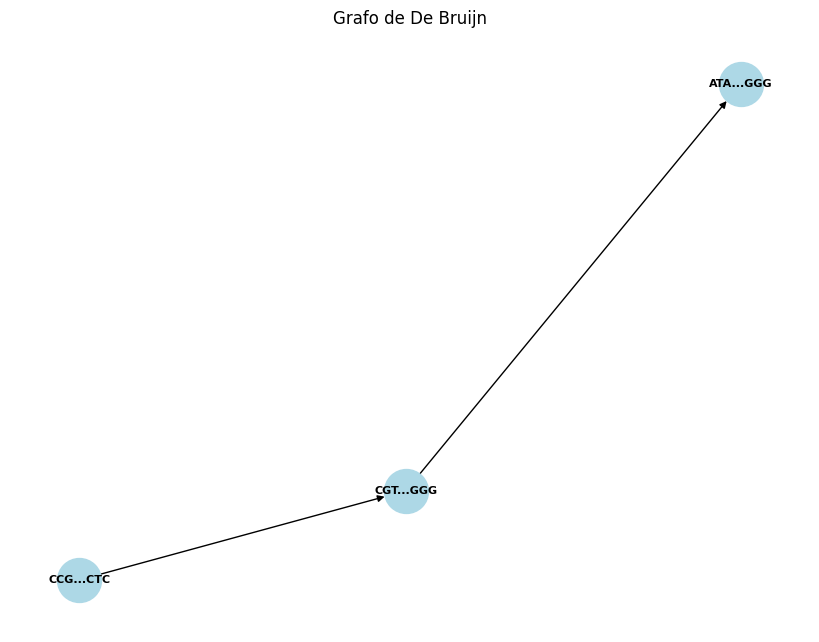

In [155]:
grafo2,nomes = manager.simplificar_grafo(grafo,caminho)
if manager.verificar_se_tem_caminho_euleriano(grafo2):
    caminho2 = manager.obter_caminho_euleriano(grafo2)
    print(f"Caminho: {caminho2}")
    genoma2 = manager.reconstruir_genoma(caminho2)
    print(f"Genoma final: {genoma2}")
    manager.desenhar_grafo(grafo2)
else:
    print("Grafo invalido")

In [157]:
print(genoma_teste)
print(genoma1)
print(genoma2)
corr = manager.comparar_genormas(genoma_teste,genoma1)
print(f"O genoma gerado 1 tem {round(100*corr,2)}% de encaixe com o genoma original")
corr = manager.comparar_genormas(genoma_teste,genoma2)
print(f"O genoma gerado 2 tem {round(100*corr,2)}% de encaixe com o genoma original")


CCGTACAAGGTTTCTGGATTGGCCTAACCAGGACCCGCCCCCCGATACTCATACTTTAGTCGGAGGTAATACAATACAGTGCAGTAGTTTGTTCATGGGG
CCGTACAAGGTTTCTGGATTGGCCTAACCAGGACCCGCCCCCCGATACTCATACTTTAGTCGGAGGTAATACAATACAGTGCAGTAGTTTGTTCATGGGG
CCGTACAAGGTTTCTGGATTGGCCTAACCAGGACCCGCCCCCCGATACTCATACTTTAGTCGGAGGTAATACAATACAGTGCAGTAGTTTGTTCATGGGG
O genoma gerado 1 tem 100.0% de encaixe com o genoma original
O genoma gerado 2 tem 100.0% de encaixe com o genoma original


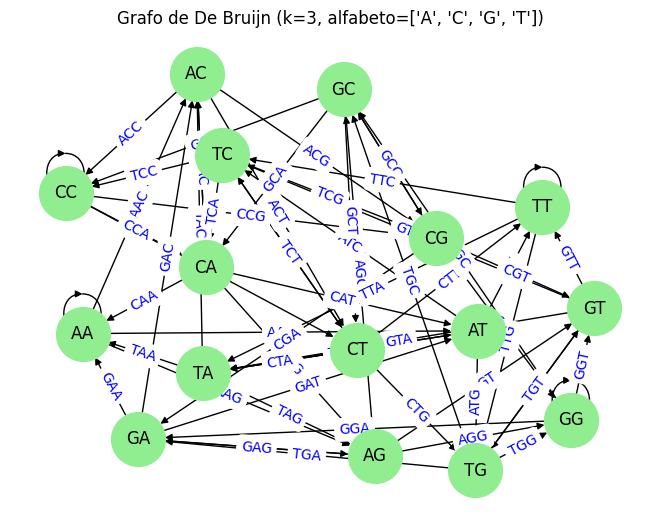

In [ ]:
# feito pelo gpt

def gerar_de_bruijn_grafo(k, alfabeto):
    G = nx.DiGraph()

    # Gerar todos os vértices possíveis com k-1 símbolos
    vertices = [''.join(p) for p in product(alfabeto, repeat=k-1)]
    G.add_nodes_from(vertices)

    # Gerar todas as arestas possíveis com k símbolos
    for p in product(alfabeto, repeat=k):
        prefixo = ''.join(p[:k-1])
        sufixo = ''.join(p[1:])
        G.add_edge(prefixo, sufixo, label=''.join(p))  # rótulo da aresta é o k-mer

    return G

# Parâmetros
k = 3
alfabeto = ['A', 'C', 'G', 'T']

# Criar o grafo
G = gerar_de_bruijn_grafo(k, alfabeto)

# Desenhar o grafo
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=1500, font_size=12, arrows=True)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue')

plt.title(f"Grafo de De Bruijn (k={k}, alfabeto={alfabeto})")
plt.show()